# Assignment 1

## Imports
All necessary imports below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unittest

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Task 1.1

### Implement a 1-NN Classifier for Time-Series Data
Here I create a 1-NN Classifier for the time-series data, with fit, predict and scoring methods that behave similarly to sklearn implementations. I use the dtw function provided to calculate distances between time series arrays.

In [2]:
class DTWOneNNClassifier():
    
    # DTW Function
    def dtw(self, s, t, window):
        n, m = len(s), len(t)
        w = np.max([window, abs(n-m)]) # warping cannot be less than the difference in lengths. 
        dtw_matrix = np.zeros((n+1, m+1))

        for i in range(n+1):
            for j in range(m+1):
                dtw_matrix[i, j] = np.inf
        dtw_matrix[0, 0] = 0

        for i in range(1, n+1):
            for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
                dtw_matrix[i, j] = 0

        for i in range(1, n+1):
            for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
                cost = abs(s[i-1] - t[j-1])
                # take last min from a square box
                last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
                dtw_matrix[i, j] = cost + last_min
        return dtw_matrix[-1,-1]

    # Fit the training and target data
    def fit(self, train, targets):
        self.train = train
        self.targets = targets
        return self
    
    # Determine nearest value based off input, default window size is 3
    def predict(self, array_of_times, window=3):
        
        # Set minimum distance to inf
        min_dist = np.inf

        # Loop through training set
        for i in range(len(self.train)):
            
            # Determine distance between input times and training set 
            dist = self.dtw(array_of_times, self.train[i], window)

            # If distance is lower than min, update min and get index
            if dist < min_dist:
                min_dist = dist
                target = i
            
        return self.targets[target]  
    
    # Determine the accuracy score
    def score(self, test_features, test_targets, window=3):
        
        # Score as a percentage of total
        total = len(test_features)
        hits = 0

        # For each test feature, check if correct or not
        for i in range(len(test_features)):
            if self.predict(test_features[i], window) == test_targets[i]:
                hits += 1
            else:
                continue
                
        return hits / total
                

### Test with sample data
Below I implement some tests on the classifier to see if it works as I expect, the tests include using two small arrays with easy to interpret values, distances and classes, and ensuring the expected classes are predicted.

In [3]:
class TestClassifier(unittest.TestCase):
    
    def test_with_dummy_data_1(self):
        t = DTWOneNNClassifier()
        t = t.fit([[1,1,1],[2,2,2]], ["Class 1", "Class 2"] )
        res = t.predict([1,1,1])
        self.assertEqual("Class 1", res)
        
    def test_with_dummy_data_2(self):
        t = DTWOneNNClassifier()
        t = t.fit([[1,1,1],[2,2,2]], ["Class 1", "Class 2"] )
        res = t.predict([2,2,2])
        self.assertEqual("Class 2", res)
        
unittest.main(argv=[''], verbosity=2, exit=False)


test_with_dummy_data_1 (__main__.TestClassifier) ... ok
test_with_dummy_data_2 (__main__.TestClassifier) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.024s

OK


# Task 1.2 Test Classifier Performance

### Using the UMD Data
Below I read in the UMD data and isolate the target and feature values. Then I divide the dataset into a training and testing split. I use the training sets to train the classifier, and then work out the accuracy of the classifier using the unseen test data.

In [4]:
UMD = pd.read_csv('UMD_TEST.txt', delimiter="  ", header=None)
UMD.head()

/var/folders/7_/wlwr4q_96fl6zfdnq30n7gmc0000gp/T/ipykernel_24230/1317055495.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  UMD = pd.read_csv('UMD_TEST.txt', delimiter="  ", header=None)


,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,1.0,0.017644,0.030949,0.050555,0.044484,0.053277,0.041576,0.030947,0.027086,0.013764,...,0.024575,0.033780,0.026589,0.013932,0.024928,0.022589,0.038248,0.049838,0.053419,0.040420
1,1.0,0.041296,0.003551,0.027470,0.013158,0.009571,0.008074,0.043743,0.040592,0.012190,...,0.060539,0.046991,0.023586,0.001562,-0.002196,0.036730,0.039027,0.007754,0.004697,0.031440
2,1.0,-0.000720,0.013283,0.029450,0.045201,0.006317,0.018805,0.028901,0.013832,0.015240,...,0.016442,0.039508,0.015171,0.034708,0.010835,0.002942,0.006924,0.029502,0.040786,0.023144
3,1.0,0.005201,0.013363,0.025733,0.026653,0.038946,0.012494,0.028303,0.032011,0.009467,...,0.006383,0.037448,0.044335,0.011143,-0.003624,0.001467,0.020991,0.027675,0.001621,0.015858
4,1.0,0.022926,0.027036,0.011668,0.019500,0.036049,-0.001297,0.019717,0.039583,0.020628,...,0.026997,0.036653,0.018117,0.018314,0.012536,0.040599,0.016590,0.032730,0.002498,0.011260


In [5]:
# Isolate the target values
y = UMD.pop(0).values
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3.])

In [6]:
# Isolate the corresponding features
X = UMD.values
X[0]

array([ 1.7644459e-02,  3.0949268e-02,  5.0555110e-02,  4.4484418e-02,
        5.3276844e-02,  4.1576200e-02,  3.0947384e-02,  2.7085506e-02,
        1.3763773e-02,  5.0538801e-03,  4.9583589e-02,  4.7378657e-03,
        2.4308760e-02,  2.4478464e-02,  4.3095075e-02,  3.1740094e-02,
        3.3707003e-02,  4.4220571e-02,  1.2100000e-01,  4.6200000e-01,
        8.1000000e-01,  1.0110000e+00,  1.1070000e+00,  1.1440000e+00,
        1.0270000e+00,  6.8500000e-01,  3.4200000e-01,  1.4900000e-01,
        5.9000000e-02,  5.5992157e-02,  1.1957117e-02,  1.0609106e-02,
        5.3351608e-02,  4.4763044e-02,  2.2176572e-02,  1.3004620e-02,
        2.3660634e-02,  2.2580103e-02,  2.4467768e-02,  3.0559437e-02,
       -4.9870111e-03,  1.9600643e-02,  3.1117836e-02,  2.3833347e-02,
        3.1311257e-02,  3.0431769e-02, -8.4000000e-02, -3.1400000e-01,
       -5.3900000e-01, -6.6200000e-01, -7.2100000e-01, -7.5000000e-01,
       -7.6400000e-01, -7.6900000e-01, -7.7000000e-01, -7.6800000e-01,
      

In [7]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 150), (48, 150), (96,), (48,))

In [8]:
# Create a classifier and fit with training data
dtw_classifier = DTWOneNNClassifier()
dtw_classifier = dtw_classifier.fit(X_train, y_train)

In [9]:
# Check accuracy with test data
acc = dtw_classifier.score(X_test, y_test)
acc

0.9166666666666666

# Task 1.3 Using Euclidian Distance

### Comparing with the Euclidian Model
Below I will implement the sklearn kNN model using Euclidian distance metrics with 1 nearest neighbour, and compare the performance with my own 1NN DTW classifier. I will then use cross validation with varying number of folds to see the effects on accuracy.

In [10]:
sk_1NN = KNeighborsClassifier(n_neighbors=1)
sk_1NN.fit(X_train, y_train)
sk_acc = sk_1NN.score(X_test, y_test)
sk_acc

0.8541666666666666

In [11]:
kNN = KNeighborsClassifier(n_neighbors=1)  
kNN_scores_2cv = cross_val_score(kNN, X, y, cv=2)
kNN_scores_4cv = cross_val_score(kNN, X, y, cv=4)
kNN_scores_6cv = cross_val_score(kNN, X, y, cv=6)
kNN_scores_8cv = cross_val_score(kNN, X, y, cv=8)
kNN_scores_10cv = cross_val_score(kNN, X, y, cv=10)

In [12]:
# Results
print('Measurement: Custom DTW Function \t\t\tAccuracy: {0:.2f}'.format(acc))
print('Measurement: Sklearn 1NN with Euclidian Distance \tAccuracy: {0:.2f}'.format(sk_acc))
print('Measurement: 2x CV 1NN with Euclidian Distance \t\tAccuracy: {0:.2f}'.format(kNN_scores_2cv.mean())) 
print('Measurement: 4x CV 1NN with Euclidian Distance \t\tAccuracy: {0:.2f}'.format(kNN_scores_4cv.mean())) 
print('Measurement: 6x CV 1NN with Euclidian Distance \t\tAccuracy: {0:.2f}'.format(kNN_scores_6cv.mean())) 
print('Measurement: 8x CV 1NN with Euclidian Distance \t\tAccuracy: {0:.2f}'.format(kNN_scores_8cv.mean())) 
print('Measurement: 10x CV 1NN with Euclidian Distance \tAccuracy: {0:.2f}'.format(kNN_scores_10cv.mean())) 

Measurement: Custom DTW Function 			Accuracy: 0.92
Measurement: Sklearn 1NN with Euclidian Distance 	Accuracy: 0.85
Measurement: 2x CV 1NN with Euclidian Distance 		Accuracy: 0.49
Measurement: 4x CV 1NN with Euclidian Distance 		Accuracy: 0.45
Measurement: 6x CV 1NN with Euclidian Distance 		Accuracy: 0.84
Measurement: 8x CV 1NN with Euclidian Distance 		Accuracy: 0.85
Measurement: 10x CV 1NN with Euclidian Distance 	Accuracy: 0.89


As seen above, the accuracy using the dtw is superior than when using euclidian distances as a metric, something likely to change even further as the window size of the dtw function is adjusted. When measuring accuracy with k-fold cross validation, we can see that as the fold sizes increase, the accuracy becomes far better, likely due to the size of the test set becoming too small, resulting in overfitting of the data.

# Task 1.4 Best Value for Window Parameter

### Determining Optimum Window Size
Below, I experiment with changing window size of the dtw function to see the effect on the accuracy of the classifier.

In [13]:
# Create a new classifier and fit with training data
dtw_classifier_windows = DTWOneNNClassifier()
dtw_classifier_windows = dtw_classifier_windows.fit(X_train, y_train)
window_results = {}

for w in range(10):
    score = dtw_classifier_windows.score(X_test, y_test, w) 
    window_results[w] = score

In [14]:
# Best window size for set
window_results

{0: 0.8541666666666666,
 1: 0.8541666666666666,
 2: 0.875,
 3: 0.9166666666666666,
 4: 0.9583333333333334,
 5: 0.9791666666666666,
 6: 0.9791666666666666,
 7: 0.9791666666666666,
 8: 0.9791666666666666,
 9: 0.9791666666666666}

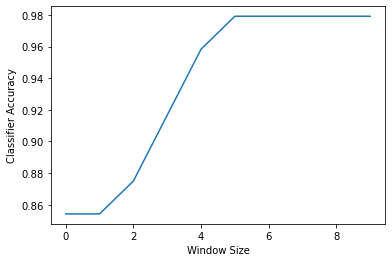

In [15]:
plt.plot(window_results.keys(), window_results.values())
plt.ylabel("Classifier Accuracy")
plt.xlabel("Window Size")
plt.show()

As we can see from the plot and `window_results` dictionary above, increasing window size increases the accuracy of the classifier until it plateaus at 5. After this point, the accuracy remains constant at 0.979167.

# Task 2.1 Adapting DTW as a Metric Function

### New Metric Function for the sklearn implementation
Below, I have altered the dtw function to create `dtw_metric`, a function which can be used in the sklearn implementation of the KNeighborsClassifier, as a metric to calculate distance. The window size has been adjusted to be a kwarg now, with a default value of 3, that can be altered by the metric_params argument of the KNeighborsClassifier.

In [16]:
def dtw_metric(s, t, **kwargs):

    # Check for window size, otherwise default to 3
    if "window" in kwargs:
        window = kwargs["window"]
    else:
        window = 3
        
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)]) # warping cannot be less than the difference in lengths. 
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[-1,-1]


# Task 2.2, 2.3
### Comparing Performance of Custom Classifier with Custom Metric Function and Euclidian Distances
Below I measure the performance of the Sklearn implementation of the KNeighborsClassifier with my new metric function. I test initially with 1NN and compare with the custom classifier, as expected, the results are the same. Then I experiment with 2 and 3 nearest neighbours of the sklearn implementation, in order to see the effect on the results. Finally, I check the performance of the model using euclidian distance with 2 and 3 nearest neighbours

In [17]:
kNN_custom = KNeighborsClassifier(n_neighbors=1, metric=dtw_metric)
kNN_custom = kNN_custom.fit(X_train, y_train)
kNN_custom = kNN_custom.score(X_test, y_test)

In [18]:
print(f"Performance of Sklearn KNClassifier with new metric function: \t{kNN_custom}")
print(f"Performance of custom classifier: \t\t\t\t{acc}")

Performance of Sklearn KNClassifier with new metric function: 	0.9166666666666666
Performance of custom classifier: 				0.9166666666666666


As expected, the performance for the classifiers is the same, as they both use the same metrics to make a classification. 

In [19]:
# Create 2 and 3 NN classifiers and check accuracy using dtw
kNN_custom_2 = KNeighborsClassifier(n_neighbors=2, metric=dtw_metric)
kNN_custom_3 = KNeighborsClassifier(n_neighbors=3, metric=dtw_metric)

kNN_custom_2 = kNN_custom_2.fit(X_train, y_train)
kNN_custom_2_scores = kNN_custom_2.score(X_test, y_test)

kNN_custom_3 = kNN_custom_3.fit(X_train, y_train)
kNN_custom_3_scores = kNN_custom_3.score(X_test, y_test)


In [20]:
# Create 2 and 3 NN using euclidian distance
kNN_euc_2 = KNeighborsClassifier(n_neighbors=2)
kNN_euc_3 = KNeighborsClassifier(n_neighbors=3)

kNN_euc_2 = kNN_euc_2.fit(X_train, y_train)
kNN_euc_2_scores = kNN_euc_2.score(X_test, y_test)

kNN_euc_3 = kNN_euc_3.fit(X_train, y_train)
kNN_euc_3_scores = kNN_euc_3.score(X_test, y_test)


In [21]:
print("Accuracy scores:")
print(f"2NN with DTW to measure distance: \t\t{kNN_custom_2_scores}")
print(f"3NN with DTW to measure distance: \t\t{kNN_custom_3_scores}")
print(f"2NN with Euclidian to measure distance: \t{kNN_euc_2_scores}")
print(f"3NN with Euclidian to measure distance: \t{kNN_euc_3_scores}")

Accuracy scores:
2NN with DTW to measure distance: 		0.875
3NN with DTW to measure distance: 		0.8958333333333334
2NN with Euclidian to measure distance: 	0.8333333333333334
3NN with Euclidian to measure distance: 	0.9375


Above we can see the accuracy of the 2 and 3 nearest neighbour classifiers using both euclidian and dtw to distance metrics. As would be expected, dynamic time warping gives a better accuracy for the classifiers than euclidian for the time series data. Similarly, as the number of neighbours increases from 2 to 3, we can see that in the case of both models the accuracy improves.